# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
from collections import deque

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="./Tennis_Linux/Tennis.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# # reset the environment
# env_info = env.reset(train_mode=True)[brain_name]

# # number of agents 
# num_agents = len(env_info.agents)
# print('Number of agents:', num_agents)

# # size of each action
# action_size = brain.vector_action_space_size
# print('Size of each action:', action_size)

# # examine the state space 
# states = env_info.vector_observations
# state_size = states.shape[1]
# print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
# print('The state for the first agent looks like:', states[0])

### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [5]:
# from unityagents import UnityEnvironment
# import numpy as np

# env = UnityEnvironment(file_name="./Tennis_Linux/Tennis.x86_64", no_graphics=False)
# # get the default brain
# brain_name = env.brain_names[0]
# brain = env.brains[brain_name]

In [6]:
def env_extractor_state(env_info):
    states = env_info.vector_observations
    states = np.expand_dims(states, axis=0)
    return states


def env_extractor_reward(env_info):
    rewards = env_info.rewards
    rewards = np.array(rewards)
    rewards = np.expand_dims(rewards, axis=0)
    return rewards 


def env_extractor_done(env_info):
    dones = env_info.local_done
    dones = np.array(dones)
    dones = np.expand_dims(dones, axis=0)
    return dones


def env_extractor_global_state(env_info):
    agent_states = env_extractor_state(env_info)
    concat_states = agent_states.reshape(-1, )
    return np.expand_dims(concat_states, axis=0)
    

def evn_extractor(env_info):
    obs = env_extractor_state(env_info)        # get next state (for each agent)
    obs_full = env_extractor_global_state(env_info)
    rewards = env_extractor_reward(env_info)      # get reward (for each agent)
    dones = env_extractor_done(env_info)
    return obs, obs_full, rewards, dones


def actor_to_simulator(actions):
    actions_for_env = torch.stack(actions).detach().numpy().reshape(number_of_agents, -1)
    actions_for_env = np.clip(actions_for_env, -1, 1)
    return actions_for_env


def actor_to_buffer(actions):
    actions_for_buffer = np.rollaxis(torch.stack(actions).detach().numpy(), 1)
    actions_for_buffer = np.clip(actions_for_buffer, -1, 1)
    return actions_for_buffer


def training_condition(buffer, episode, episode_per_update, number_of_episode_before_training):
    condition = list()
    condition.append(len(buffer) >= batchsize)
    condition.append(episode % episode_per_update == 0)
    condition.append(episode > number_of_episode_before_training)
    if all(condition):
        return True
    return False

In [7]:
from buffer import ReplayBuffer
from maddpg import MADDPG
import torch
import numpy as np
from tensorboardX import SummaryWriter
import os
from utilities import transpose_list, transpose_to_tensor
import imageio

def seeding(seed=1):
    np.random.seed(seed)
    torch.manual_seed(seed)


!sh ./clean.sh
seeding()
# number of training episodes.
buffer = ReplayBuffer(int(1e5))
scenario = {'regular' : [1500, 1000, 128*4], 'test' : [1, 1, 1]}
scenario_type = 'regular'
number_of_episodes = scenario[scenario_type][0]
episode_length = scenario[scenario_type][1]
batchsize = scenario[scenario_type][2]
episode_per_update = 1 
parallel_envs = 1
number_of_agents = 2
action_size = 2
number_of_episode_before_training = 100
number_of_learning_per_episode = 3
save_interval = 100
noise = 1
noise_reduction = 0.99995

maddpg = MADDPG(number_of_agents, action_size)
scores_deque = deque(maxlen=100) 
scores_list = list()
score_trailing_100 = list()

In [8]:
for episode in range(0, number_of_episodes):
    reward_this_episode = np.zeros((parallel_envs, number_of_agents))
    env_info = env.reset(train_mode=True)[brain_name] 
    obs, obs_full, _, _ = evn_extractor(env_info)
    save_info = (episode % save_interval == 0)

    for episode_t in range(episode_length):
        actions = maddpg.act(transpose_to_tensor(obs), noise=noise)
        noise *= noise_reduction
        actions_for_env = actor_to_simulator(actions)
        actions_for_buffer = actor_to_buffer(actions)    
        env_info = env.step(actions_for_env)[brain_name] 
        next_obs, next_obs_full, rewards, dones = evn_extractor(env_info)
        transition = (obs, obs_full, actions_for_buffer, rewards, next_obs, next_obs_full, dones)
        buffer.push(transition)
        reward_this_episode += rewards
        
        if np.any(dones) or (episode_t + 1 == episode_length):
            break

        obs, obs_full = next_obs, next_obs_full

    # update once after every episode_per_update
    if training_condition(buffer, episode, episode_per_update, number_of_episode_before_training):
        for _ in range(number_of_learning_per_episode): #learn multiple times at every step
            for a_i in range(number_of_agents):
                samples = buffer.sample(batchsize)
                maddpg.update(samples, a_i)
            maddpg.update_targets() #soft update the target network towards the actual networks


    max_reward_episode = np.max(reward_this_episode)
    scores_deque.append(max_reward_episode)
    scores_list.append(max_reward_episode)
    score_trailing_100.append(np.mean(scores_deque))
    
    if episode % 50 == 0:
        print('\rEpisode {} \t Episode Max Reward {:.3f} \t  Average Trailing Max Score: {:.3f} noise_factor {}'\
              .format(episode, max_reward_episode, np.mean(scores_deque), str(noise)))



Episode 0 	 Episode Max Reward 0.000 	  Average Trailing Max Score: 0.000 noise_factor 0.9992502624431336
Episode 50 	 Episode Max Reward 0.000 	  Average Trailing Max Score: 0.004 noise_factor 0.961749771408627
Episode 100 	 Episode Max Reward 0.000 	  Average Trailing Max Score: 0.009 noise_factor 0.9210397755409134
Episode 150 	 Episode Max Reward 0.000 	  Average Trailing Max Score: 0.012 noise_factor 0.8837747214124038
Episode 200 	 Episode Max Reward 0.000 	  Average Trailing Max Score: 0.008 noise_factor 0.8498001550169711
Episode 250 	 Episode Max Reward 0.000 	  Average Trailing Max Score: 0.005 noise_factor 0.8190951784183292
Episode 300 	 Episode Max Reward 0.000 	  Average Trailing Max Score: 0.004 noise_factor 0.7883556604525456
Episode 350 	 Episode Max Reward 0.000 	  Average Trailing Max Score: 0.010 noise_factor 0.756534626191744
Episode 400 	 Episode Max Reward 0.100 	  Average Trailing Max Score: 0.018 noise_factor 0.7224853568613586
Episode 450 	 Episode Max Reward 

(0.0, 0.05364000085741281)

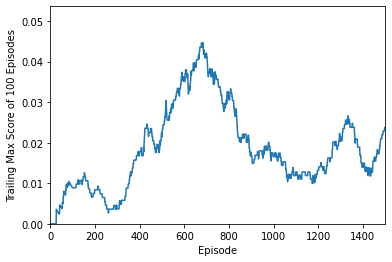

In [9]:
from matplotlib import pyplot as plt
plt.plot(score_trailing_100)
plt.xlabel("Episode")
plt.ylabel("Trailing Max Score of 100 Episodes")
plt.xlim(0, number_of_episodes)
plt.ylim(0, max(score_trailing_100)*1.2)

# Testing The Agents 

In [10]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment
    obs, obs_full, rewards, dones = evn_extractor(env_info)# get the current state (for each agent)
    scores = np.zeros(number_of_agents)                          # initialize the score (for each agent)
    while True:
        actions = maddpg.act(transpose_to_tensor(obs), noise=noise)
        actions_for_env = torch.stack(actions).detach().numpy().reshape(number_of_agents, -1)
        actions_for_env = np.clip(actions_for_env, -1, 1)
        env_info = env.step(actions_for_env)[brain_name]   # send all actions to tne environment
        obs, obs_full, rewards, dones = evn_extractor(env_info)   # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
#         print(dones, rewards)
        scores += env_info.rewards                         # update the score (for each agent)                             # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 0.09000000171363354
Score (max over agents) from episode 2: 0.0
Score (max over agents) from episode 3: 0.0
Score (max over agents) from episode 4: 0.0
Score (max over agents) from episode 5: 0.0
